# Importing Basic Libraries 

In [5]:
import keras
import tensorflow as tf
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [4]:
import random as rn
import numpy as np
import pandas as pd
import os
import glob
import datetime
import pandas as pd

# 1. Load the data

In [6]:
os.chdir('D:\\Research Papers\\Economics\\Banking Index Analysis')
df = pd.read_csv('Banking Index.csv')

# 2. Make data stationery. 

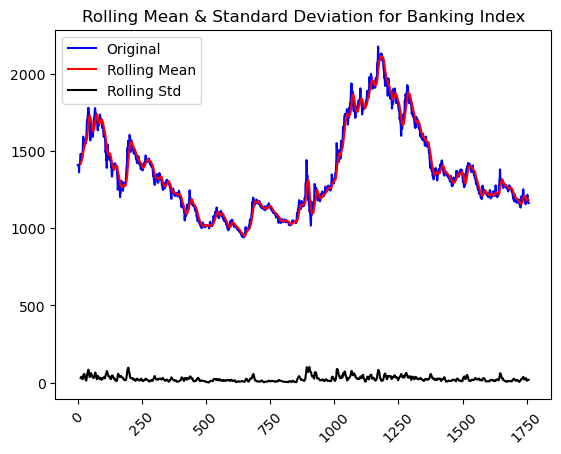

Results of Dickey-Fuller Test:
Test Statistic                   -1.486005
p-value                           0.540423
# Lags Used                       2.000000
Number of Observations Used    1756.000000
Critical Value (1%)              -3.434079
Critical Value (5%)              -2.863187
Critical Value (10%)             -2.567647
dtype: float64


In [7]:
# Defining a function to test stationarity
#SOURCE:https://github.com/tklouie/PyData_LA_2018/blob/master/PyData_LA_2018_Tutorial.ipynb

import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.x13
from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots

def test_stationarity(df, ts):

    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()

    # Plot rolling statistics:
    orig = plt.plot(df[ts], color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()

    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = statsmodels.tsa.stattools.adfuller(df[ts], autolag='AIC') #add kpss
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value', '# Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
#Applying the function to our Y variable: SCB
test_stationarity(df, 'Banking Index')

In [61]:
#Defining a function to calculate percentage change
def percentChange(x,numLags):
    '''
    INPUTS:
    x: Column for which we want to calculate percent change
    numLags: The number of days from when the change needs to be calculated. 
            Example : If using daily data - numLags = 1 for daily change
                                            numLags = 30 for monthly change
                                            numLags = 365 for yearly change       
    OUTPUT:
    percentage change in variable
    '''
    y = (x - x.shift(numLags))/x.shift(numLags)
    return y

dataForMl = pd.DataFrame()


In [16]:
import pandas as pd

# Assuming df is your DataFrame
# Assuming percentChange is a function that calculates percentage change
def percentChange(series, lag=1):
    numeric_series = pd.to_numeric(series, errors='coerce')
    return numeric_series.pct_change(periods=lag)

# Assuming dataForMl is your target DataFrame
dataForMl = pd.DataFrame()

for levelVar in df.columns:
    # Convert the column to numeric and then calculate percentage change
    dataForMl[f'{levelVar}Ret'] = percentChange(df[levelVar], 1)

# Remove the first row as it may contain null values after calculating percentage change
dataForMl = dataForMl[1:].reset_index(drop=True)

In [17]:
# Print column names of dataForMl
print(dataForMl.columns)

Index(['SNRet', 'Banking IndexRet', 'Total TurnoverRet',
       'Banking TurnoverRet'],
      dtype='object')


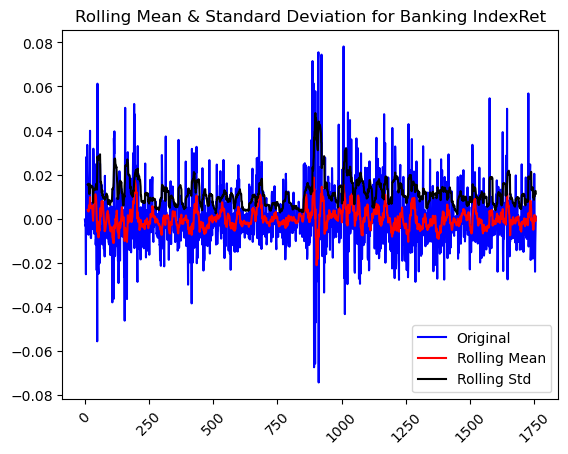

Results of Dickey-Fuller Test:
Test Statistic                  -29.622651
p-value                           0.000000
# Lags Used                       1.000000
Number of Observations Used    1756.000000
Critical Value (1%)              -3.434079
Critical Value (5%)              -2.863187
Critical Value (10%)             -2.567647
dtype: float64


In [18]:
test_stationarity(dataForMl, 'Banking IndexRet')

- From the above graphs, we see that the percentage change in Banking Index (i.e. Banking IndexRet) is stationary as the p-value is less that 0.05. 
- Again, for greater intuition look at the graph - the rolling mean and rolling standard deviation lines are along are almost flat meaning that they don't change in a statistically significant manner over time.
- However, do note that taking the first difference does not necessarily have to make the data stationary.

# 4. Lagging The Data

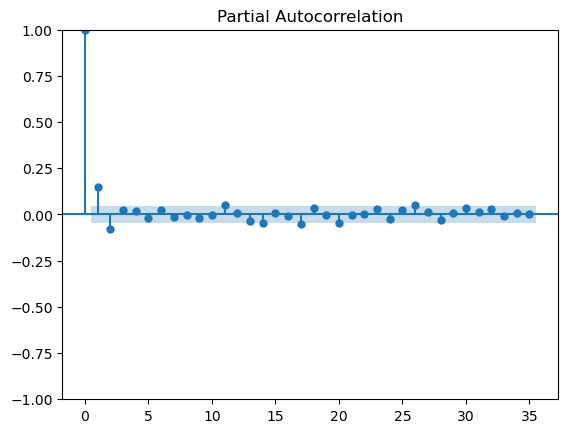

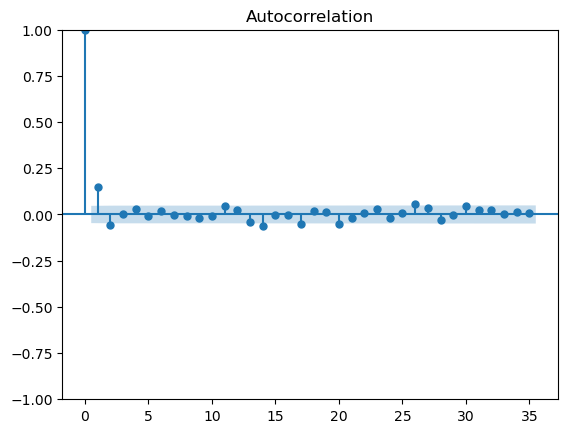

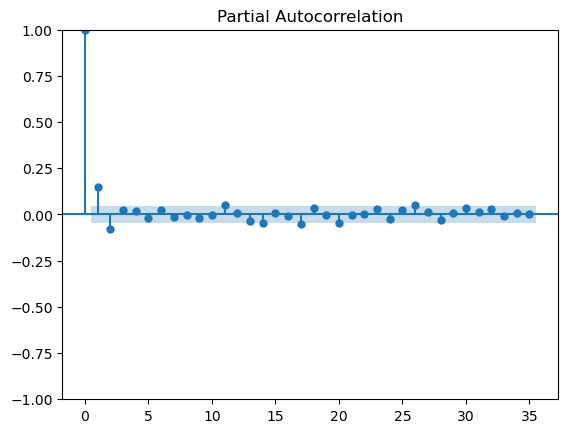

In [19]:

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf

tsaplots.plot_acf(dataForMl['Banking IndexRet'].astype(float),lags =35)
tsaplots.plot_pacf(dataForMl['Banking IndexRet'].astype(float),lags =35)

Both ACF and PACF shows good serial coorelation at first lag.

# Training, Validation and Testing

In [20]:

#removing columns if nan value in a column
dataForMl = dataForMl.dropna()

#specifying independent variables:including only lagged versions of variables and excluding date variables
final_vars = [col for col in dataForMl.columns if (col.find('Lag')!=-1) & (col.find('date')==-1)]

#specifying the dependent variable
dep_var = 'Banking IndexRet'

#always make the dependent ariable the last column in the dataset
final_vars.append(dep_var)

#for later use
dataForMl_copy = dataForMl

#keeping only relevant 
dataForMl = dataForMl[final_vars]

In [21]:
# Assuming df is your original DataFrame
def percentChange(x, numLags):
    y = (x - x.shift(numLags)) / x.shift(numLags)
    return y

# Assuming 'SCB' is the column you want to apply percentage change to
dataForMl = pd.DataFrame()
dataForMl['Banking IndexRet'] = percentChange(df['Banking Index'], 1)

# Drop rows with NaN values
dataForMl.dropna(inplace=True)

# Verify the DataFrame
print(dataForMl.head())

# Split the data into training, testing, validation, and out-of-sample
test_percent = 0.30
no_test_obs = int(np.round(test_percent * len(dataForMl)))
training = dataForMl[:-no_test_obs]
testing = dataForMl[-no_test_obs:]

# Breaking the testing data into validation and out-of-sample data
validation_percent = 0.90
no_validation_obs = int(np.round(validation_percent * len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]

   Banking IndexRet
1         -0.000355
2         -0.001570
3         -0.003295
4         -0.002656
5         -0.025208


# Data Normalization

Normalize the data in the training sample because machine learning methods are not scale invarient.

Normalizing on training data to avoid data leakage.

Using the python sklearn liabrary, 's very useful for this.

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Check the size of outOfSample
print(outOfSample.shape)

(474, 1)


In [23]:
print(training.shape), print(training.head())

(1231, 1)
   Banking IndexRet
1         -0.000355
2         -0.001570
3         -0.003295
4         -0.002656
5         -0.025208


(None, None)

In [48]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
trainMinmax = min_max_scaler.fit_transform(training.values)  # Only scale the 'Banking Index' column
valMinmax = min_max_scaler.transform(validation.values)
outSampleMinmax = min_max_scaler.transform(outOfSample.values)

In [24]:
print("Testing DataFrame:")
print(testing.shape)

print("Out of Sample DataFrame:")
print(outOfSample.shape)

print("Validation DataFrame:")
print(validation.shape)

Testing DataFrame:
(527, 1)
Out of Sample DataFrame:
(474, 1)
Validation DataFrame:
(53, 1)


In [49]:
#breaking the data into independent variables (x) and dependent variables (y)

#training independent, dependent
trainMinmax_x,trainMinmax_y = trainMinmax[:,:-1],trainMinmax[:,-1] 

#validation independent, dependent
valMinmax_x,valMinmax_y = valMinmax[:,:-1],valMinmax[:,-1]

#out of sample testing independent, dependent
outSampleMinmax_x,outSampleMinmax_y = outSampleMinmax[:,:-1],outSampleMinmax[:,-1]


In [43]:
#DEFINING SARIMA MODEL
import statsmodels.tsa.stattools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

#(p,d,q) are determined using  Autocorrelation Function (ACF) , Partial Autocorrelation Functions (PACF) and tests for stationary.  
#How do we interpret ACF and PACF plots?

#p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
#q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

p= 1 #the trend autoregressive order.
d= 0 #the trend difference order.
q= 1 #the trend moving average order

P= 1 #the number of seasonal autoregressive terms.
D= 0 #the number of seasonal difference terms
Q= 1 #the number of seasonal moving average terms
M=1 #the number of time steps for a seasonal period 

# Specify the seasonal period (replace with the appropriate value if needed)
M = 12 # For monthly seasonality

# Define the orders
myorder = (p, d, q)
myseasonalorder = (P, D, Q, M)  # M is included here

# Create the model
model = sm.tsa.statespace.SARIMAX(
    trainMinmax_y,
    order=myorder,
    seasonal_order=myseasonalorder,
    trend='c'
)  # ,exog=trainMinmax_x  (uncomment if using exogenous variables)

# Train the model
model_fit = model.fit()

# ... (rest of your code for prediction and other tasks)

# In case you want to add exgogenous variables
#exogNormal = normalizer.transform(testing.values)
#exogMinmax = min_max_scaler.transform(exogNormal)
#exogMinmax_x,exogMinmax_y = exogMinmax[:,:-1],exogMinmax[:,-1]

#Predicting
totat_preds = len(testing)#len(exogMinmax_y)
sarimaPred = model_fit.predict(start=1, end=totat_preds)#exog=exogMinmax_x

In [44]:

def plot_results(actual_y,predicted_y,method,date):
    mse = mean_squared_error(actual_y,predicted_y)
    
    plt.figure(figsize=(16,4))
    plt.plot(date,actual_y)
    plt.plot(date,predicted_y)
    plt.legend(['Actual','Predicted'])
    plt.title(f'{method} (MSE: {mse})')        
    plt.show()


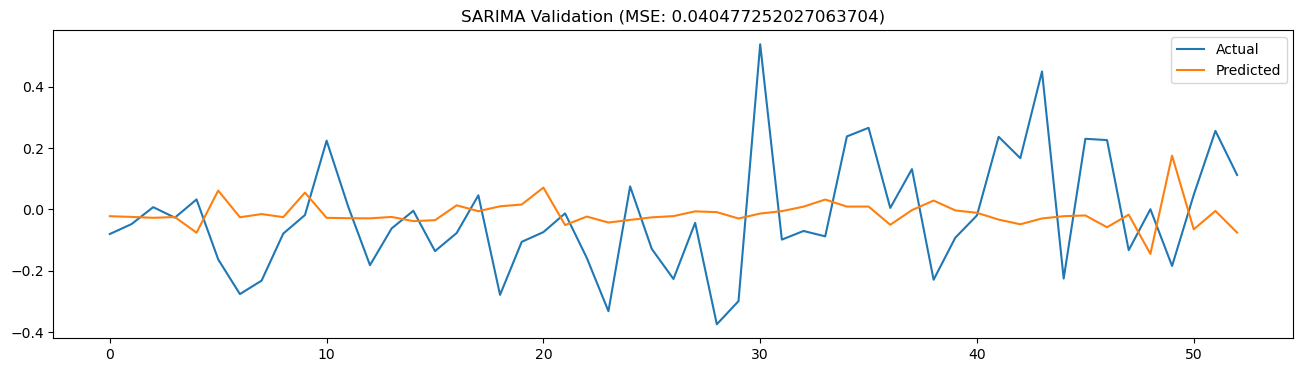

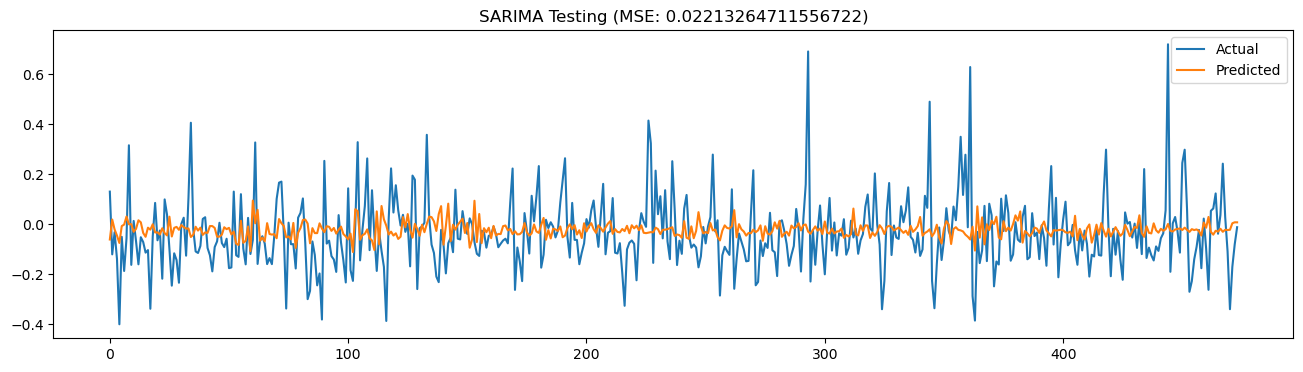

In [32]:
plot_results(valMinmax_y,sarimaPred[:len(valMinmax_y)],'SARIMA Validation',range(len(valMinmax_y)))
plot_results(outSampleMinmax_y,sarimaPred[len(valMinmax_y):],'SARIMA Testing',range(len(outSampleMinmax_y)))

# Neural Networks

In [41]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix, :-1] if sequences.shape[1] > 1 else sequences[i:end_ix, :]
        seq_y = sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [55]:

from numpy import array
n_steps_in =10 #number of observations from the past that we assume to be relevant across time for forecasting
n_steps_out = 1 #number of units ahead that we want to forecast into the future

#training sequence
trainSeq_x, trainSeq_y = split_sequences(trainMinmax, n_steps_in,n_steps_out)

#out of sample sequence
validationSeq_x, validationSeq_y= split_sequences(valMinmax, n_steps_in,n_steps_out)

#out of sample sequence
outSampleSeq_x, outSampleSeq_y= split_sequences(outSampleMinmax, n_steps_in,n_steps_out)

In [56]:
trainMinmax.shape #Output: (rows,columns)

(1231, 1)

In [57]:
trainSeq_x.shape #Output: (number of samples,size of 'window' /timesteps,number of independent variables)

(1222, 10, 1)

# # Convolutional Neural Network

In [2]:
# Implementing a neural network in Keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling1D,MaxPooling1D
from keras.layers import Conv1D,AveragePooling1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.layers import BatchNormalization
from keras.regularizers import l1,l2,l1_l2

In [59]:
############################# For Replicability : Always run this as one cell ##########################################
#SOURCE :
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_seed(1234)
#from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.keras.backend.clear_session()
tf.compat.v1.keras.backend.set_session(sess)
###########################################################################################################################

#While training the neural network, it is important that we use the MSE error of the validation set to decide when to 
#stop training our network. If we use the MSE of the training set, we will not get good predictions in the test set due 
#to over fitting. However, unlike the error in the training set, the error in the validation set does not reduce with 
#every passing epoch. Sometimes, it increases for a while before it starts declining. The patience argument in Earlystop allows us 
#to decide how many times we want the validation error to keep increasing before we stop training the neural network.

EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto',restore_best_weights=True)

epochs = 100000 #number of times the feed forward mechanism and back propagation are repeated 

bs = 100 #batch size for SGD :show what happens when batch size very small
lr =0 #learning rate: the degree to which the weights are updated by each batch of SGD

sgd = SGD(lr=lr) #type of optimizer - Alternative: ADAM, NADAM

X, y = split_sequences(trainMinmax, n_steps_in,n_steps_out)
n_features = X.shape[2]

np.random.seed(0)

model = Sequential() #initializing keras Sequential model

#convolutional layer starts
model.add(Conv1D(filters=5,#number of filters
                 kernel_size=2,#size of the filte racross time
                 strides=2, #number of rows that the filter moves ahead by
                 activation='linear',#transformation
                 input_shape=(n_steps_in, n_features))) #shape of 1 sample : preserves temporal structure
                #kernel_regularizer=l2(0.009),, bias_regularizer=l2(0.01)
#convolutional layer ends

model.add(MaxPooling1D(pool_size=1)) #sub-sampling layer - Alternative: AveragePooling1D

#model.add(BatchNormalization())
model.add(Dropout(0.1)) #reduces overfitting by dropping some weights randomly

#regression layer begins
model.add(Flatten())
model.add(Dense(1,#number of outputs
                activation='tanh',#transformation:other options include - ReLU,Linear,Sigmoid
                kernel_regularizer=l2(0.01))) 

model.compile(loss='mean_squared_error', optimizer='sgd') #specifies which optimizer and loss funtion to useto use 

#training the model
model.fit(trainSeq_x, trainSeq_y,
          batch_size=bs,
          epochs=epochs, 
          callbacks= [EarlyStop] ,
          verbose=2, 
          shuffle=False,#always set to false for time series data
          validation_data =(validationSeq_x, validationSeq_y))
                         
    
model.summary()



Epoch 1/100000

13/13 - 1s - loss: 0.0661 - val_loss: 0.0706 - 1s/epoch - 92ms/step
Epoch 2/100000
13/13 - 0s - loss: 0.0638 - val_loss: 0.0695 - 75ms/epoch - 6ms/step
Epoch 3/100000
13/13 - 0s - loss: 0.0650 - val_loss: 0.0685 - 75ms/epoch - 6ms/step
Epoch 4/100000
13/13 - 0s - loss: 0.0626 - val_loss: 0.0675 - 70ms/epoch - 5ms/step
Epoch 5/100000
13/13 - 0s - loss: 0.0626 - val_loss: 0.0665 - 69ms/epoch - 5ms/step
Epoch 6/100000
13/13 - 0s - loss: 0.0611 - val_loss: 0.0656 - 70ms/epoch - 5ms/step
Epoch 7/100000
13/13 - 0s - loss: 0.0602 - val_loss: 0.0647 - 68ms/epoch - 5ms/step
Epoch 8/100000
13/13 - 0s - loss: 0.0590 - val_loss: 0.0639 - 68ms/epoch - 5ms/step
Epoch 9/100000
13/13 - 0s - loss: 0.0599 - val_loss: 0.0630 - 67ms/epoch - 5ms/step
Epoch 10/100000
13/13 - 0s - loss: 0.0593 - val_loss: 0.0622 - 71ms/epoch - 5ms/step
Epoch 11/100000
13/13 - 0s - loss: 0.0582 - val_loss: 0.0614 - 75ms/epoch - 6ms/step
Epoch 12/100000
13/13 - 0s - loss: 0.0568 - val_loss: 0.0606 - 73ms/epoc

In [78]:
pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


15/15 [==============================] - 0s 2ms/step


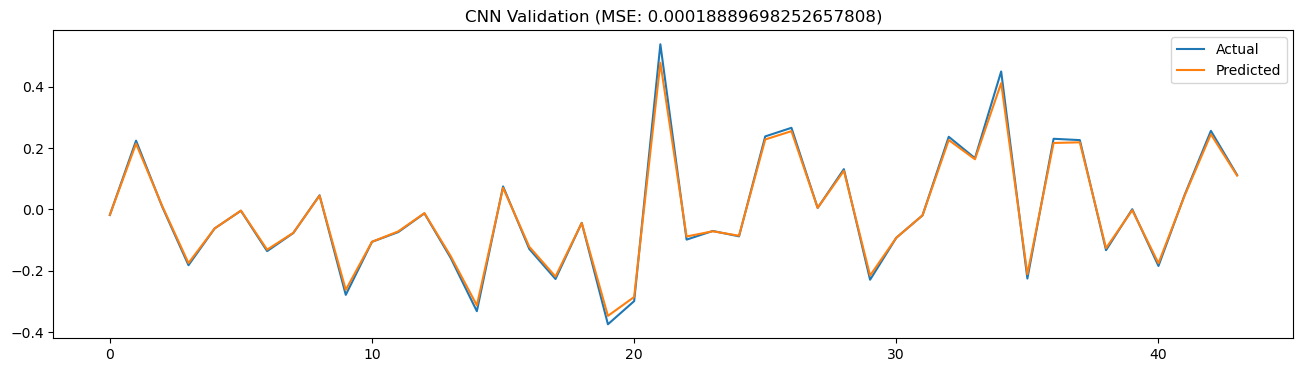

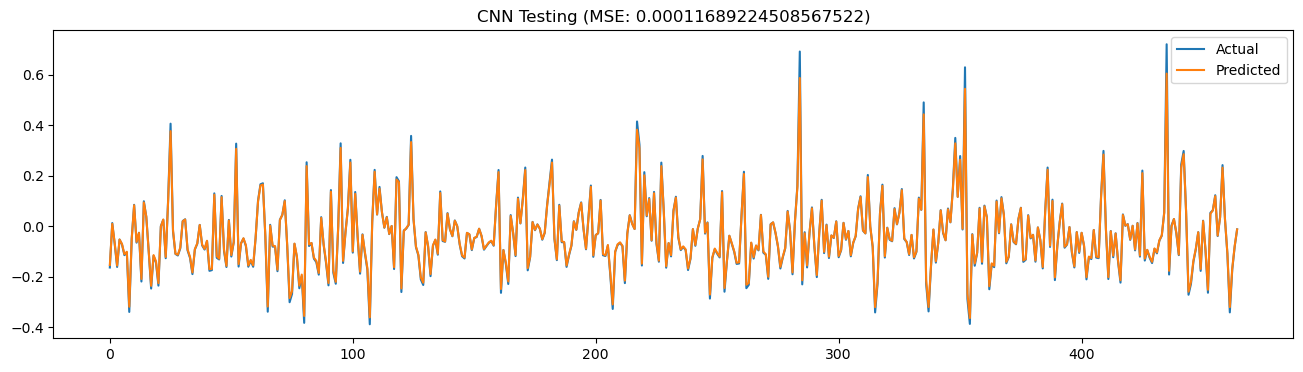

In [60]:
# validation metrics 
cnnValPred = model.predict(validationSeq_x)

#testing prediction
cnnOutSamplePred = model.predict(outSampleSeq_x)
    
plot_results(validationSeq_y ,cnnValPred  ,'CNN Validation',range(len(validationSeq_y)))
plot_results(outSampleSeq_y ,cnnOutSamplePred  ,'CNN Testing',range(len(outSampleSeq_y)))